## Autoencoders

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Prepare data 

In [3]:
x,y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name, ignore_verifications=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Create a function to move arrays to tensors


In [4]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(item) for item in b[x]]

In [5]:
bs = 256
tfds = dsd.with_transform(transformi)

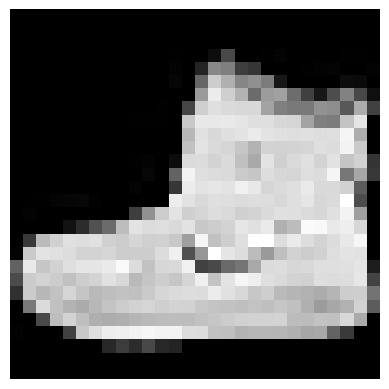

In [7]:
trds = tfds['train']
img = trds[0]['image']
show_image(img);

In [40]:
len(trds), img.shape

(60000, torch.Size([1, 28, 28]))

In [12]:
tfds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [8]:
cf = collate_dict(trds)

In [9]:
cf

<function miniai.datasets.collate_dict.<locals>._f(b)>

In [10]:
# create a function to move the output of the collate dict onto the relevant device
def collate_(b): return to_device(cf(b))

Now create dataloader function to create train and test dataloaders

In [13]:
def data_loaders(tfds, bs, **kwargs): return {k: DataLoader(v, bs, **kwargs) for k, v in tfds.items()} 

In [14]:
dls = data_loaders(tfds, bs, collate_fn=collate_)

In [15]:
dls

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fd0956a4340>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fd0956a4490>}

In [16]:
dlt = dls['train']
dlv = dls['test']

In [19]:
xb, yb = next(iter(dlt))

In [28]:
labels = trds.features['label'].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

itemgetter in this context will return the item in the list of labels that is indexed by the tnesor in each item of yb passed to the definition

In [31]:
 lbl_getter = itemgetter(*yb[:16])

In [34]:
titles = lbl_getter(labels)

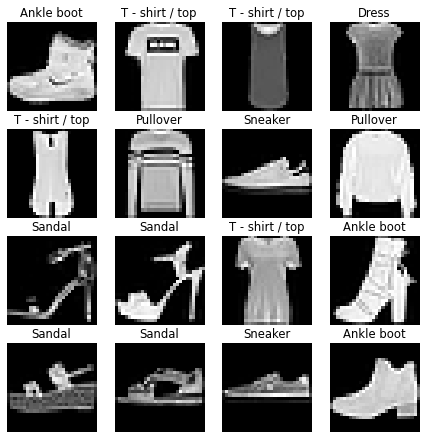

In [37]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], ncols=4, titles=titles, imsize=1.9)

## Start with a classifier 

In [39]:
from torch import optim
bs = 256
lr = 0.4

In [46]:
cnn = nn.Sequential(
    conv(1, 4),   #14x14
    conv(4, 8),   #7x7
    conv(8, 16),  #4x4
    conv(16, 16), #2x2
    conv(16, 10, act=False),
    nn.Flatten())

cnn = cnn.to(def_device)

In [55]:
opt = optim.SGD(cnn.parameters(), lr=lr)
fit(5, cnn, F.cross_entropy, opt, dlt, dlv)

Epoch: 0, loss: 0.41280585527420044, acc: 0.8486999869346619
Epoch: 1, loss: 0.40540051460266113, acc: 0.8522999882698059
Epoch: 2, loss: 0.405124694108963, acc: 0.8538999557495117
Epoch: 3, loss: 0.3973197042942047, acc: 0.8575999736785889
Epoch: 4, loss: 0.3993237018585205, acc: 0.8565999865531921


## Autoencoder 

The above architecture provides a relatively simple compression part of the autoencoder, the next part is the expansion part. This needs a deconvolution layer that is the reverse of 'conv'

In [57]:
def deconv(ni, nf, ks=3, act=True):
    """ Apply an upsampling layer followed by a stride one convolution to provide some training capability.
    Apply an optional activation function
    """
    layers = [
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(ni, nf, kernel_size=ks, stride=1, padding=ks//2)
    ]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

Also required is an eval function that will evaluate metrics on the validation dataset.  In this case the metrics will be the loss and the accuracy

In [71]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        total_loss = 0.
        count = 0
        for xb, _ in valid_dl:
            preds = model(xb)
            loss = loss_func(preds, xb)
            samples = len(yb)
            count += samples
            # The loss function returns the mean of the loss, we need the total
            total_loss += loss.item() * samples
        print(f"Epoch: {epoch}, Loss: {total_loss / count}")
            

Create an updated fit function

In [72]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    # Iterate through epochs
    for epoch in range(epochs):
        #train
        model.train()
        # For an autoencoder we don't need yb, as the target is also the input
        for xb, _ in train_dl:
            preds = model(xb)
            loss = loss_func(preds, xb)
            loss.backward()
            opt.step()
            opt.zero_grad()            
        #eval
        eval(model, loss_func, valid_dl, epoch)

Create a very basic convolutional autoencoder

In [73]:
ae = nn.Sequential(
    nn.ZeroPad2d(2),   # 32x32
    conv(1, 2),        # 16x16
    conv(2, 4),        # 8x8
    #conv(4, 8),       # 4x4
    #deconv(8, 4),     # 8x8
    deconv(4, 2),      # 16x16
    deconv(2, 1, act=False), #32x32
    # remove the padding
    nn.ZeroPad2d(-2),  #28x28
    nn.Sigmoid()
).to(def_device)

In [74]:
opt = optim.SGD(ae.parameters(), lr=0.01)

In this case mse loss will be used initially since the target to to reproduce individual pixels

In [75]:
fit(5, ae, F.mse_loss, opt, dlt, dlv)

Epoch: 0, Loss: 0.1540693998336792
Epoch: 1, Loss: 0.1380709819495678
Epoch: 2, Loss: 0.12804188020527363
Epoch: 3, Loss: 0.1222362194210291
Epoch: 4, Loss: 0.11731332447379827


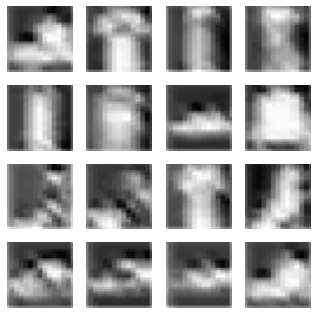

In [76]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.4, ncols=4)

In [79]:
opt = optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.mse_loss, opt, dlt, dlv)

Epoch: 0, Loss: 0.04291253406554461
Epoch: 1, Loss: 0.0325960663612932
Epoch: 2, Loss: 0.029686033399775623
Epoch: 3, Loss: 0.027766943303868176
Epoch: 4, Loss: 0.02583810919895768


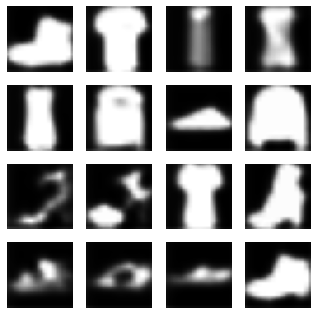

In [80]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.4, ncols=4)

The above results are not very good. In order to be able to improve the model further it is necessary to have additional tools available to improve the model training and stability.  Hence further developmemt will continue after the tools are developed